In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from time import time
from fvcore.nn import FlopCountAnalysis
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC
from src.models.lbcnn.axial_unet import AxialUNet, SmallAxialUNet
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP
from src.models.unet.unet_model import UNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, DSCUNetLBP
from src.models.dsc.dsc_unet import UNetDSC
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, lraspp_mobilenet_v3_large
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC, LargeAxialLBC
import torch
from src.datasets.ice import Ice
import numpy as np
import os
from torch import nn
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
import torch.nn.functional as F

In [51]:
def eval_model(model: nn.Module, checkpoint_path: str, title: str, mobile: bool = False) -> None:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.train()
    out = nn.Softmax(dim=1)

    mask_list, pred_list = [], []

    img = val_set[IMG_NUMBER]['image'].to(device=device).unsqueeze(0)
    mask = val_set[IMG_NUMBER]['mask'].to(device=device, dtype=torch.long).unsqueeze(0)

    if mobile:
        imgs = torch.stack([img, img], dim=0).squeeze(1)
        with torch.no_grad():
            output = model(imgs)['out']
        sftmx = out(output)
        argmx = torch.argmax(sftmx, dim=1)[0].unsqueeze(0)
        hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
        iou = jaccard_index(hist)[0]
        acc = per_class_pixel_accuracy(hist)[0]
        loss = F.cross_entropy(output[0].unsqueeze(0), mask.squeeze(1)).detach().item()
    else:
        with torch.no_grad():
            output = model(img)
        sftmx = out(output)
        argmx = torch.argmax(sftmx, dim=1)
        hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
        iou = jaccard_index(hist)[0]
        acc = per_class_pixel_accuracy(hist)[0]
        loss = F.cross_entropy(output, mask.squeeze(1)).detach().item()
    
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    img_np = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    axs[0].imshow(img_np[:, :, 0])
    mask_np = mask.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    axs[1].imshow(mask_np)
    argmx_np = argmx.permute(1, 2, 0).detach().cpu().numpy()
    axs[2].imshow(argmx_np)
    if mobile:
        sftmx_np = sftmx.squeeze(0)[0].permute(1, 2, 0).detach().cpu().numpy()
    else:
        sftmx_np = sftmx.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    axs[3].imshow(sftmx_np[:, :, 2])
#     axs[3].hist(sftmx_np[:, :, 1])
    fig.suptitle(title + f"\n acc: {acc:.2f}, iou: {iou:.2f}, loss: {loss:.2f}");

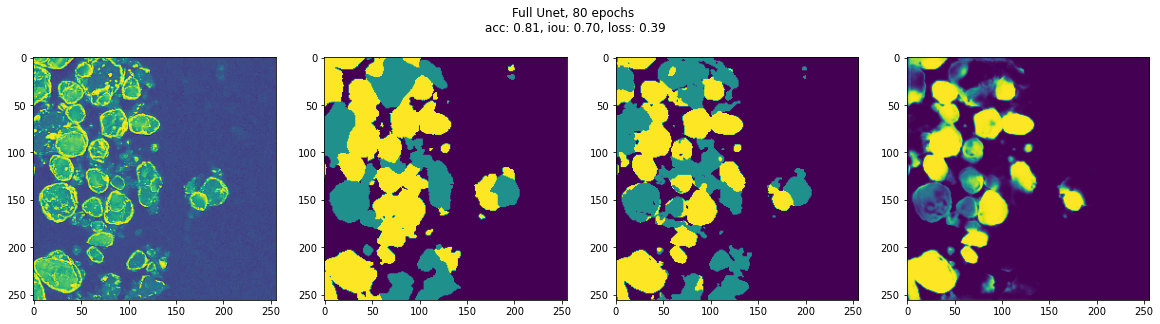

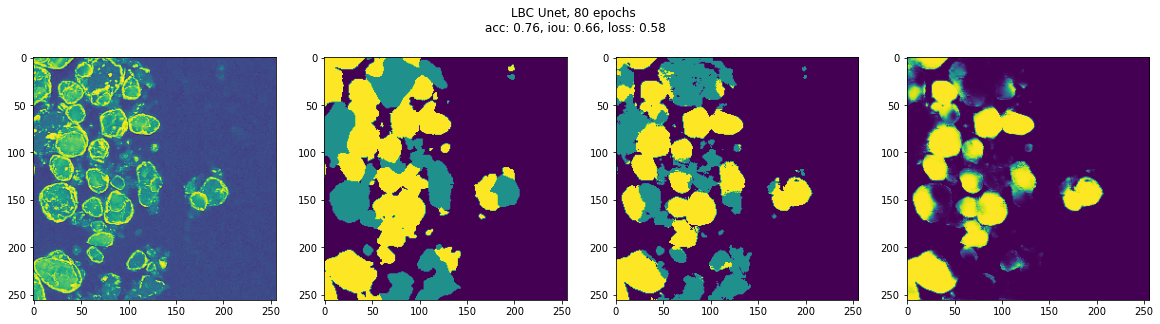

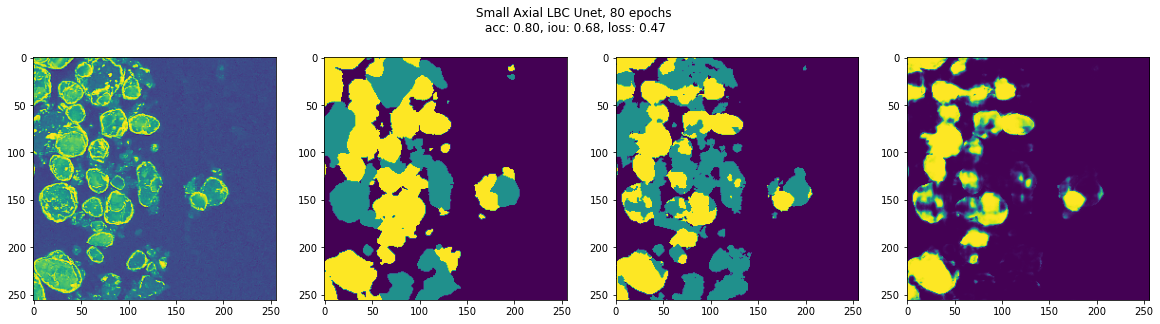

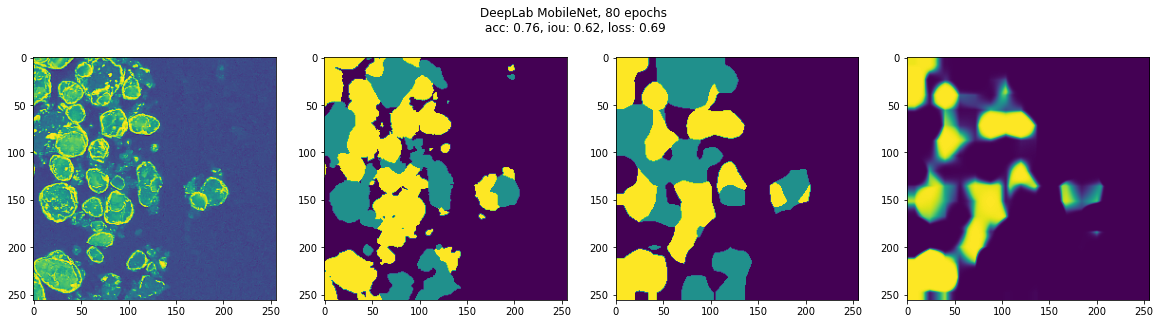

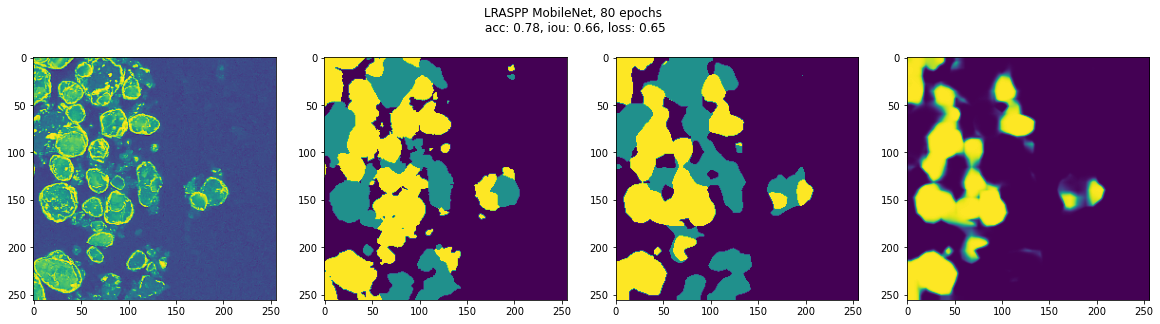

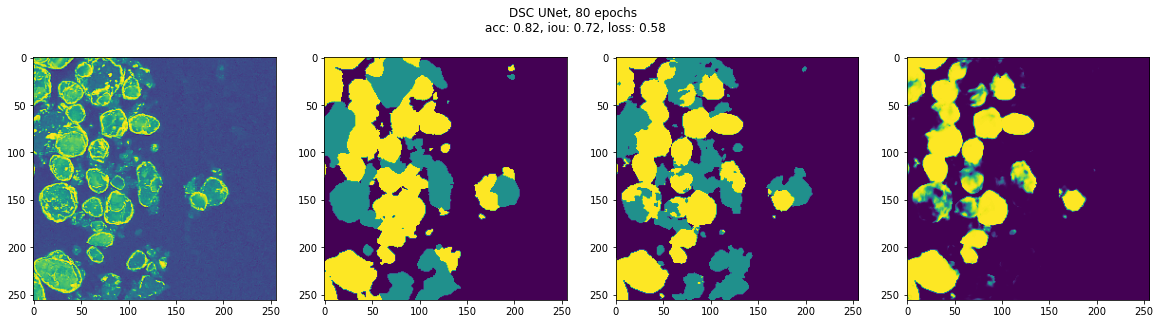

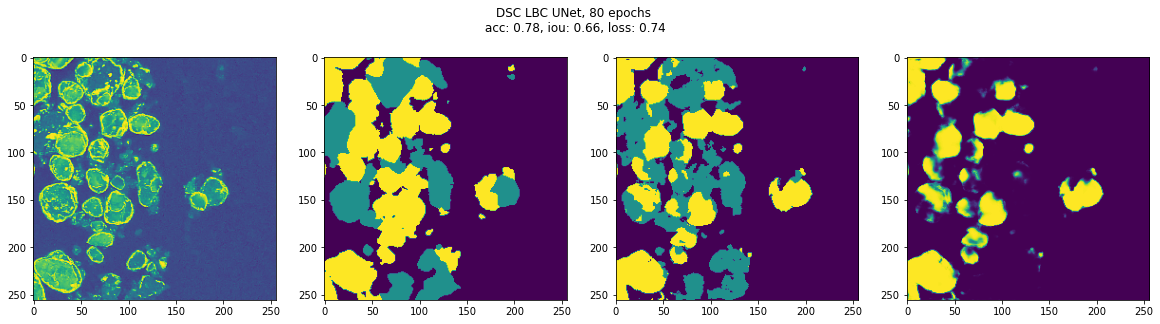

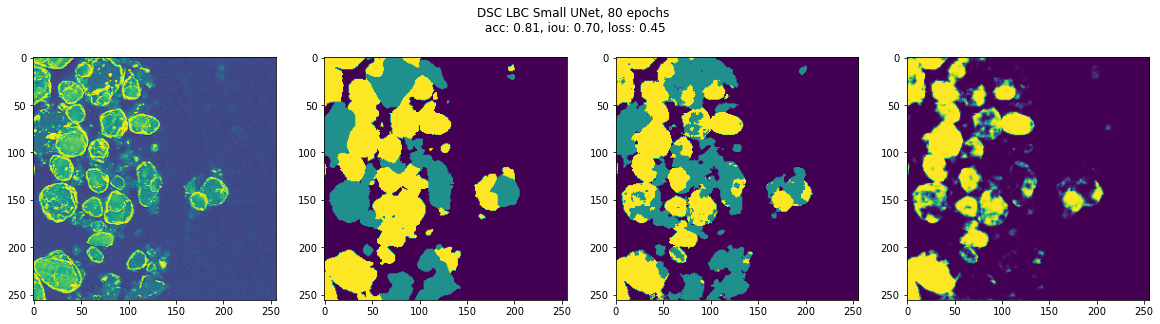

In [53]:
IMG_NUMBER = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1
img_crop = 256
img_scale = 0.35

val_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
              os.path.join(data_dir, 'txt_files'), 'val', img_scale, img_crop)

eval_model(
    UNet(n_channels=3, n_classes=3, bilinear=True).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/frosty_sponge_239_unet_ice/epoch80.pth', 
    'Full Unet, 80 epochs'
)
eval_model(
    UNetLBP(3, 3).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/worthy_wood_227_lbc_unet_ice/epoch80.pth', 
    'LBC Unet, 80 epochs'
)
eval_model(
    SmallAxialUNetLBC(3, 3, 10).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/glamorous_breeze_180_small_axial_unet_lbc_ice/epoch80.pth', 
    'Small Axial LBC Unet, 80 epochs'
)
eval_model(
    deeplabv3_mobilenet_v3_large(num_classes=3).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/vivid_donkey_305_deeplab_mobilenet_ice/epoch80.pth', 
    'DeepLab MobileNet, 80 epochs',
    mobile=True
)
eval_model(
    lraspp_mobilenet_v3_large(num_classes=3).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/clean_darkness_312_laraspp_mobilenet_ice/epoch80.pth', 
    'LRASPP MobileNet, 80 epochs',
    mobile=True
)
eval_model(
    UNetDSC(n_channels=3, n_classes=3, bilinear=True).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/helpful_fire_308_unet_dsc_ice/epoch80.pth', 
    'DSC UNet, 80 epochs'
)
eval_model(
    DSCUNetLBP(3, 3).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/youthful_microwave_310_lbc_dsc_unet_ice/epoch80.pth', 
    'DSC LBC UNet, 80 epochs'
)
eval_model(
    DSCSmallUNetLBP(3, 3).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/still_paper_311_small_lbc_dsc_unet_ice/epoch80.pth', 
    'DSC LBC Small UNet, 80 epochs'
)